In [19]:
pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 5.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [122]:
import csv
import os
import json
import argparse
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [123]:
scamdigger_dataset_path = "/kaggle/input/cs5344-dataset/scam_profiles_output.csv" #2021 onwards
datingnmore_dataset1_path = "/kaggle/input/cs5344-dataset/result_1_501.csv"
datingnmore_dataset2_path = "/kaggle/input/cs5344-dataset/result_500_1000.csv" #2018 onwards

scam_df = pd.read_csv(scamdigger_dataset_path)
dating_df1 = pd.read_csv(datingnmore_dataset1_path)
datingn_df2 = pd.read_csv(datingnmore_dataset1_path)

scam_df.shape, dating_df1.shape, datingn_df2.shape

((2622, 17), (15030, 17), (15030, 17))

In [124]:
datingnmore_df = pd.concat([dating_df1, datingn_df2], ignore_index=True)
datingnmore_df.shape

(30060, 17)

In [125]:
scam_df.columns = scam_df.columns.str.lower()
scam_df = scam_df.rename(columns = {'looking':'target','purpose':'intent'})

In [126]:
scam_df['age'] = scam_df['age'].fillna('').astype(str).str.extract(r'(\d+)').astype(float)
datingnmore_df['age'] = datingnmore_df['age'].str.extract(r'(\d+)').astype(float)
scam_df['status'] = scam_df['status'].str.lower()
datingnmore_df = datingnmore_df[datingnmore_df['ethnicity'] != 'error']
scam_df['ethnicity'] = scam_df['ethnicity'].str.lower() #fill in nan value with mod later
scam_df['occupation'] = scam_df['occupation'].str.lower()
datingnmore_df['occupation'] = datingnmore_df['occupation'].str.lower() #fill '-' with mod later
datingnmore_df['location'] = datingnmore_df['location'].str.lower()
scam_df['location'] = scam_df['location'].str.lower()

In [127]:
scam_df.loc[scam_df['children'] == 'I have 1-2 children living with me','children'] = '1-2 living with me'
scam_df.loc[scam_df['children'] == 'I have 1-2 children living elsewhere','children'] = '1-2 living elsewhere'
scam_df.loc[scam_df['children'] == 'I don’t have children','children'] = 'no children'
scam_df.loc[scam_df['children'] == 'I want children','children'] = 'want children'
scam_df.loc[scam_df['children'] == 'I have 3 or or more children living elsewhere','children'] = 'more than 2 living elsewhere'
scam_df.loc[scam_df['children'] == 'I have 3 or more children living with me','children'] = 'more than 2 living with me'
scam_df.loc[scam_df['children'] == 'I don’t want children','children'] = "don't want children"
scam_df.loc[scam_df['children'] == 'don’t want children','children'] = "don't want children" #nan

In [128]:
def update_looking(value):
    if pd.isna(value):
        return value
    if 'Both' in value or 'Male, Female' in value:
        return 'Both'
    return value
scam_df['target'] = scam_df['target'].apply(update_looking)
datingnmore_df['target'] = datingnmore_df['target'].apply(update_looking)

In [129]:
def check_purposes(df):
    purposes = ['Friendship', 'Romance', 'Serious Relationship', 'Marriage', 'Fun']
    for purpose in purposes:
        # Create a new column for each purpose, assigning 1 if it's present, otherwise 0
        df[f'intent_{purpose.replace(" ", "_")}'] = df['intent'].apply(
            lambda x: 1 if isinstance(x, str) and purpose in x else 0
        )

    return df

scam_df = check_purposes(scam_df)
datingnmore_df = check_purposes(datingnmore_df)

scam_df = scam_df.drop('intent', axis=1)
datingnmore_df = datingnmore_df.drop('intent', axis=1)

In [130]:
scam_df = scam_df.dropna(subset=['age'])

In [131]:
scam_df_model = scam_df[['age','target','location','status','children','orientation',
                         'ethnicity','religion','occupation','description','intent_Friendship',
                         'intent_Romance','intent_Serious_Relationship','intent_Marriage','intent_Fun']]

datingnmore_df_model = datingnmore_df[['age','target','location','status','children','orientation',
                         'ethnicity','religion','occupation','description','intent_Friendship',
                         'intent_Romance','intent_Serious_Relationship','intent_Marriage','intent_Fun']]

In [132]:
scam_df_model['scammer']=1
datingnmore_df_model['scammer']=0

In [133]:
merge_df = pd.concat([scam_df_model, datingnmore_df_model], ignore_index=True)

In [134]:
def fill_missing_with_mode(df, columns):
    for col in columns:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
    return df

columns_to_fill = ['status', 'target', 'children','orientation','ethnicity','religion']
merge_df = fill_missing_with_mode(merge_df, columns_to_fill)

In [135]:
merge_df['city'] = merge_df['location'].str.extract(r'([^,-,-–]+)')[0]
merge_df['city'] = merge_df['city'].str.replace(r'\d+', '', regex=True)
merge_df['city'] = merge_df['city'].str.strip()

In [136]:
nan_in_columns = merge_df.isna().any()
print(nan_in_columns)

age                            False
target                         False
location                        True
status                         False
children                       False
orientation                    False
ethnicity                      False
religion                       False
occupation                      True
description                     True
intent_Friendship              False
intent_Romance                 False
intent_Serious_Relationship    False
intent_Marriage                False
intent_Fun                     False
scammer                        False
city                            True
dtype: bool


In [137]:
merge_df.fillna({'location': 'unknown', 'occupation': 'unknown','description': 'unknown','city': 'unknown'}, inplace=True)
merge_df['occupation'] = merge_df['occupation'].replace('-', 'unknown')

# EDA

In [138]:
import matplotlib.pyplot as plt
scammer_df = merge_df[merge_df['scammer'] == 1]
non_scammer_df = merge_df[merge_df['scammer'] == 0]

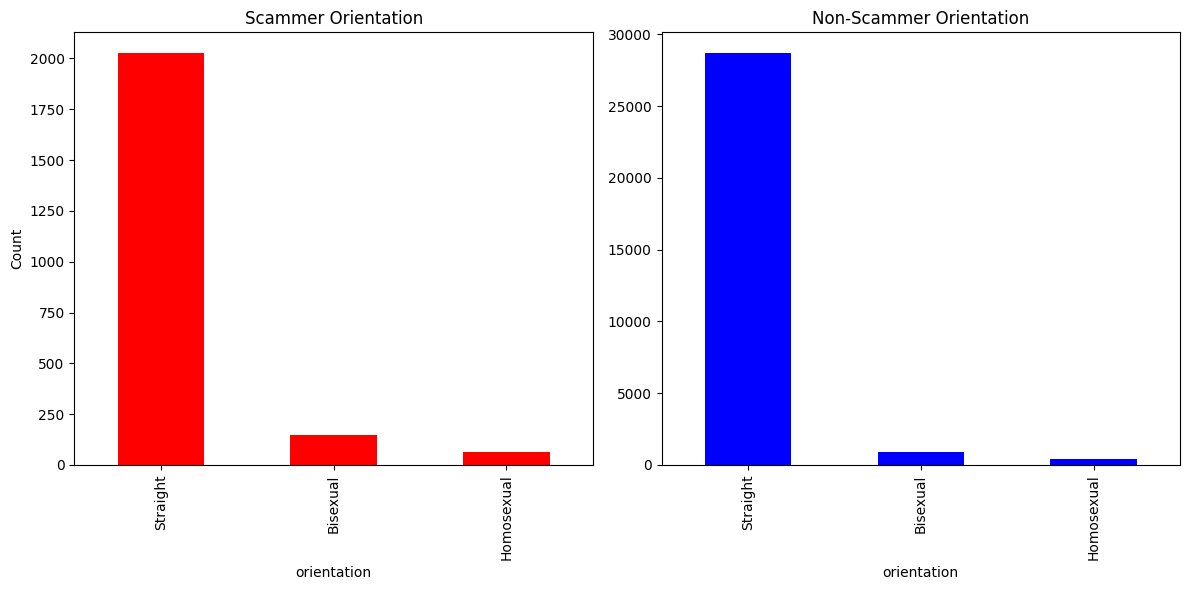

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

scammer_df['orientation'].value_counts().plot(kind='bar', ax=axes[0], color='red', title='Scammer Orientation')
axes[0].set_ylabel('Count')

non_scammer_df['orientation'].value_counts().plot(kind='bar', ax=axes[1], color='blue', title='Non-Scammer Orientation')

plt.tight_layout()
plt.show()

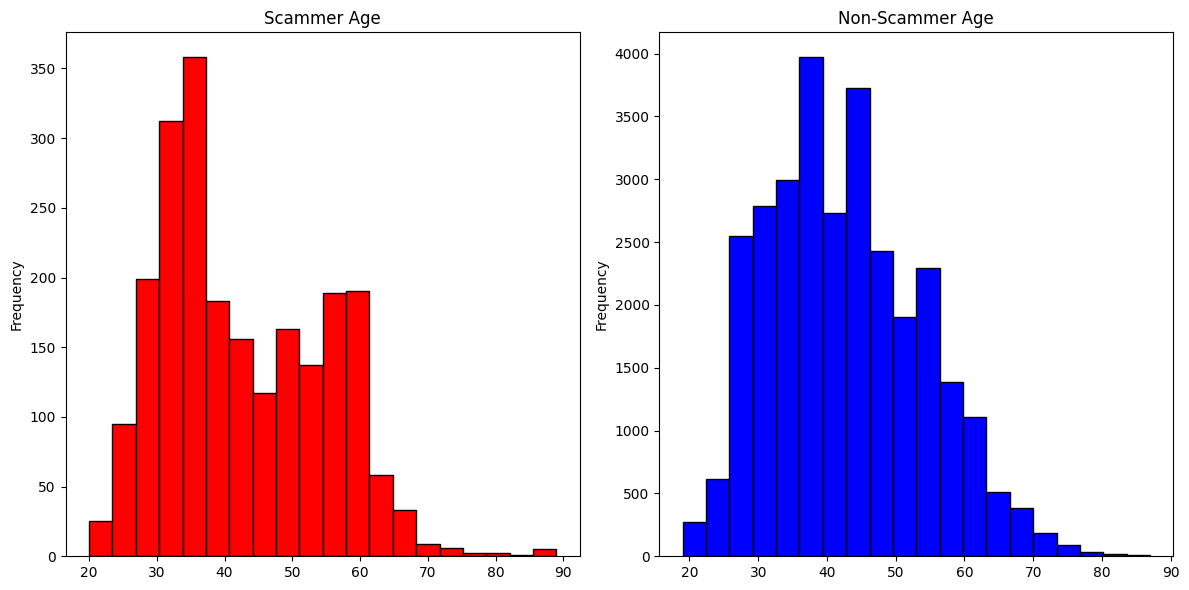

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scammer Age Distribution
scammer_df['age'].plot(kind='hist', bins=20, edgecolor='black', ax=axes[0], color='red', title='Scammer Age')
axes[0].set_ylabel('Frequency')

# Non-Scammer Age Distribution
non_scammer_df['age'].plot(kind='hist', bins=20, edgecolor='black', ax=axes[1], color='blue', title='Non-Scammer Age')

plt.tight_layout()
plt.show()

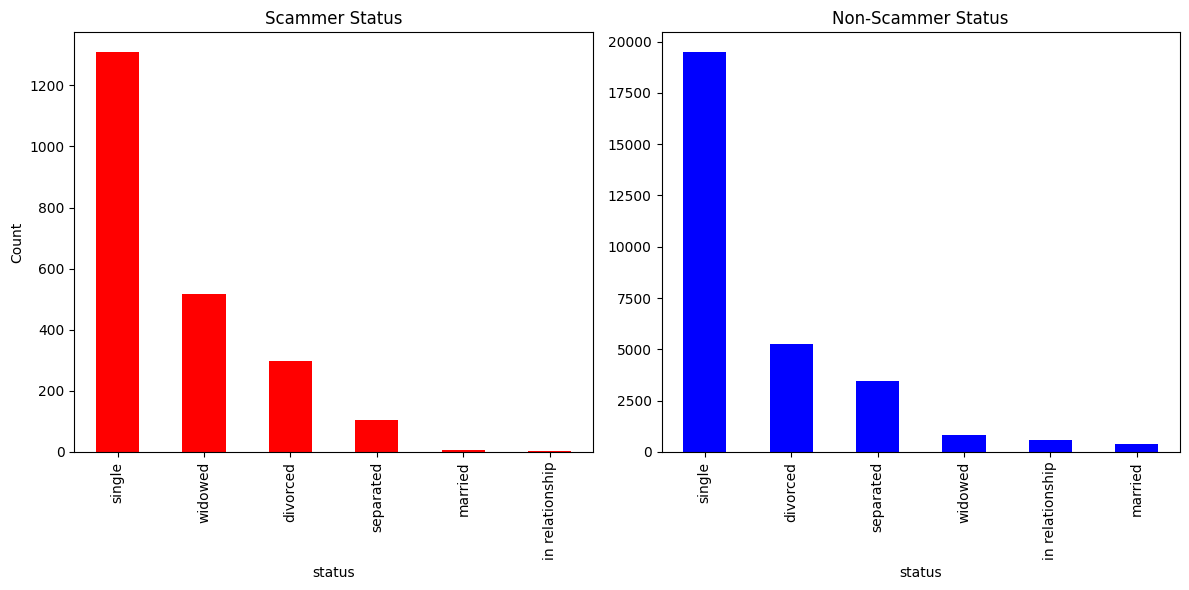

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scammer Status Distribution
scammer_df['status'].value_counts().plot(kind='bar', ax=axes[0], color='red', title='Scammer Status')
axes[0].set_ylabel('Count')

# Non-Scammer Status Distribution
non_scammer_df['status'].value_counts().plot(kind='bar', ax=axes[1], color='blue', title='Non-Scammer Status')

plt.tight_layout()
plt.show()

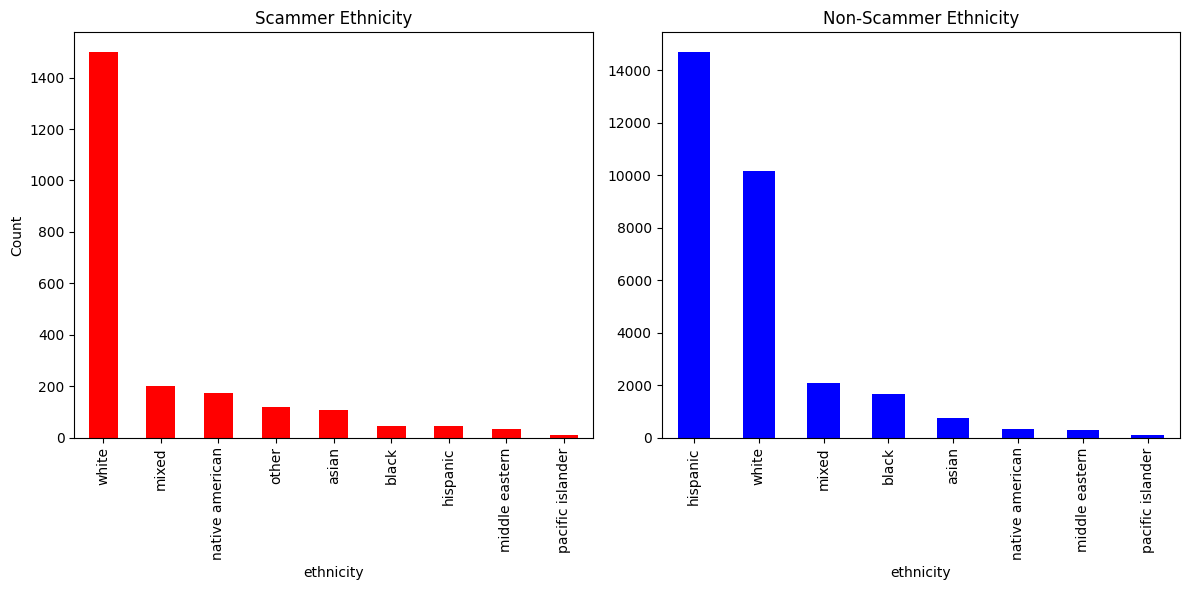

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scammer Ethnicity Distribution
scammer_df['ethnicity'].value_counts().plot(kind='bar', ax=axes[0], color='red', title='Scammer Ethnicity')
axes[0].set_ylabel('Count')

# Non-Scammer Ethnicity Distribution
non_scammer_df['ethnicity'].value_counts().plot(kind='bar', ax=axes[1], color='blue', title='Non-Scammer Ethnicity')

plt.tight_layout()
plt.show()

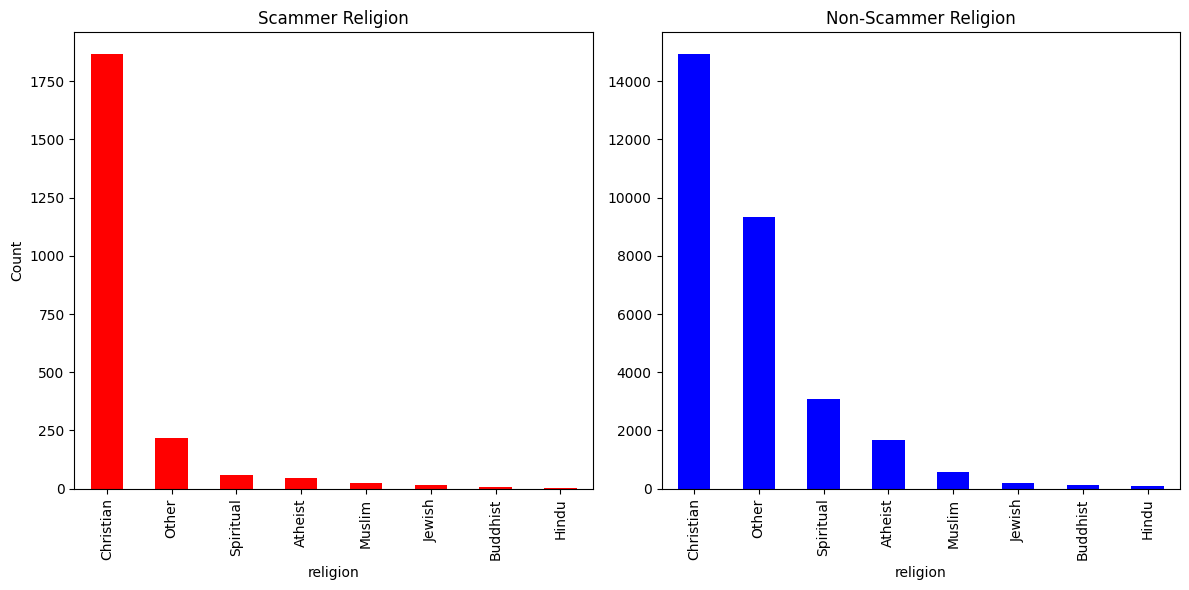

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scammer Religion Distribution
scammer_df['religion'].value_counts().plot(kind='bar', ax=axes[0], color='red', title='Scammer Religion')
axes[0].set_ylabel('Count')

# Non-Scammer Religion Distribution
non_scammer_df['religion'].value_counts().plot(kind='bar', ax=axes[1], color='blue', title='Non-Scammer Religion')

plt.tight_layout()
plt.show()

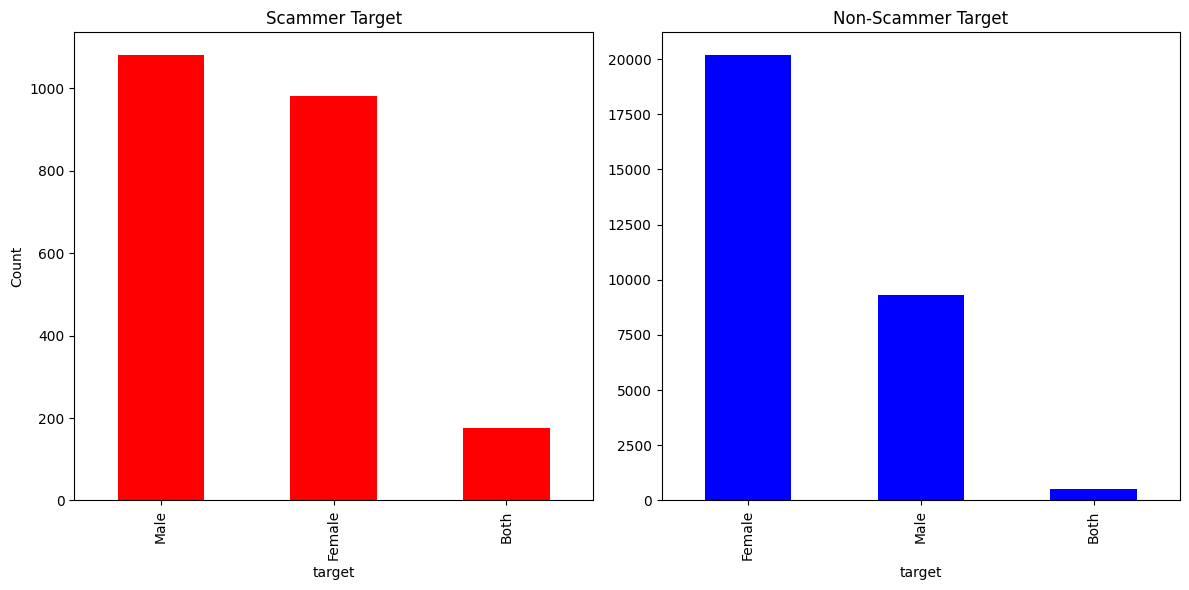

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scammer Religion Distribution
scammer_df['target'].value_counts().plot(kind='bar', ax=axes[0], color='red', title='Scammer Target')
axes[0].set_ylabel('Count')

# Non-Scammer Religion Distribution
non_scammer_df['target'].value_counts().plot(kind='bar', ax=axes[1], color='blue', title='Non-Scammer Target')

plt.tight_layout()
plt.show()

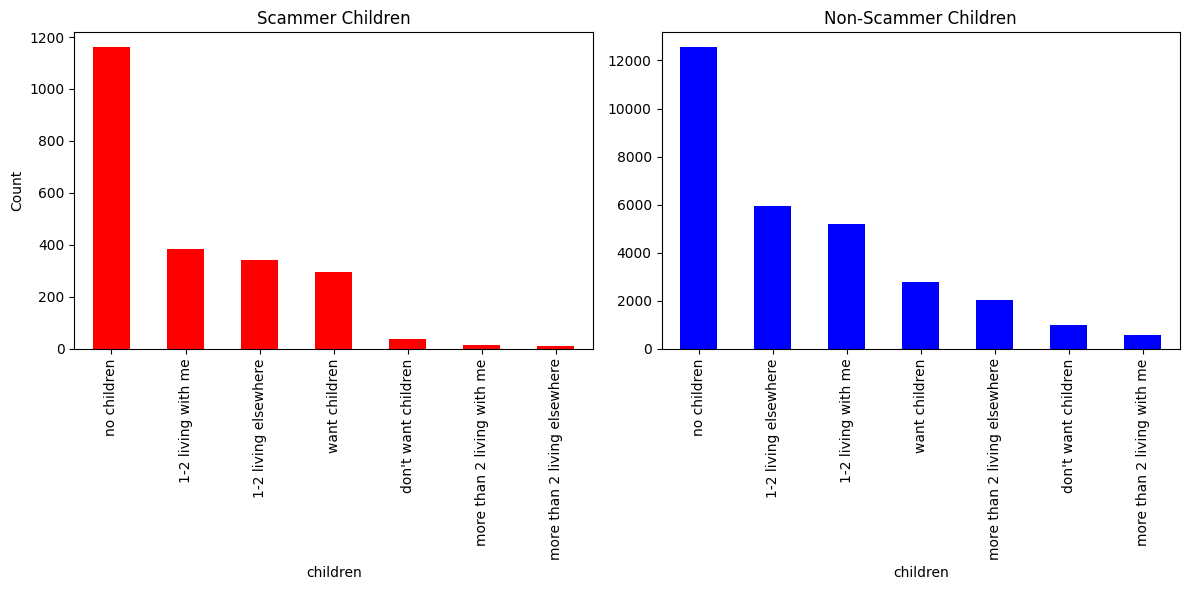

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scammer Religion Distribution
scammer_df['children'].value_counts().plot(kind='bar', ax=axes[0], color='red', title='Scammer Children')
axes[0].set_ylabel('Count')

# Non-Scammer Religion Distribution
non_scammer_df['children'].value_counts().plot(kind='bar', ax=axes[1], color='blue', title='Non-Scammer Children')

plt.tight_layout()
plt.show()

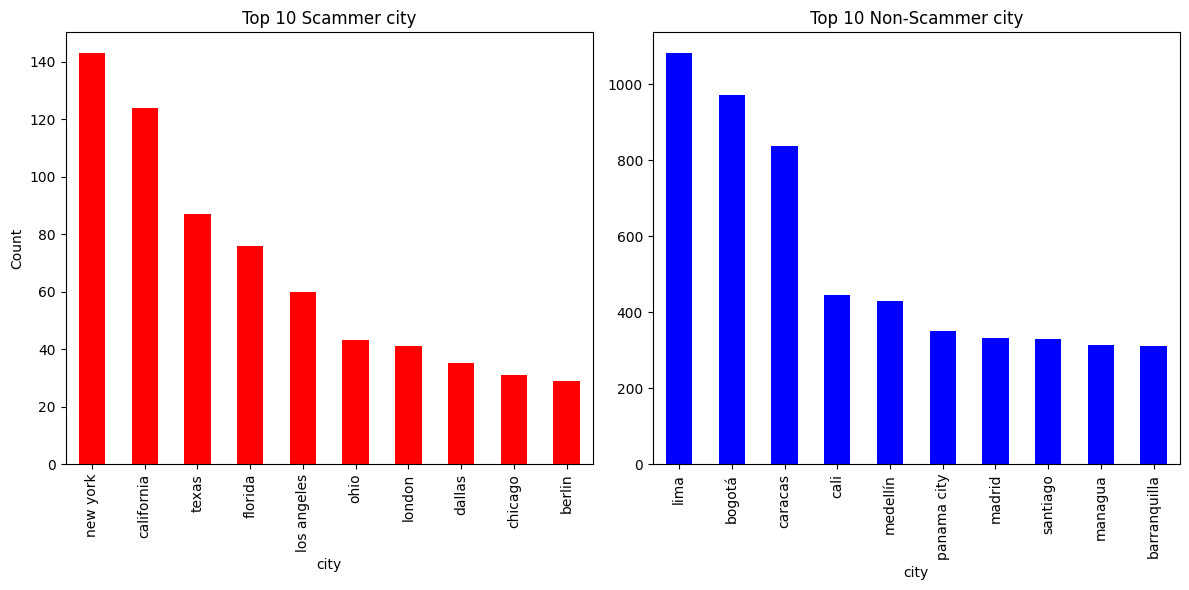

In [146]:
top_10_scammer_locations = scammer_df['city'].value_counts().nlargest(10)
top_10_non_scammer_locations = non_scammer_df['city'].value_counts().nlargest(10)

# Create subplots for Location Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Top 10 Scammer Locations
top_10_scammer_locations.plot(kind='bar', ax=axes[0], color='red', title='Top 10 Scammer city')
axes[0].set_ylabel('Count')

# Top 10 Non-Scammer Locations
top_10_non_scammer_locations.plot(kind='bar', ax=axes[1], color='blue', title='Top 10 Non-Scammer city')

plt.tight_layout()
plt.show()

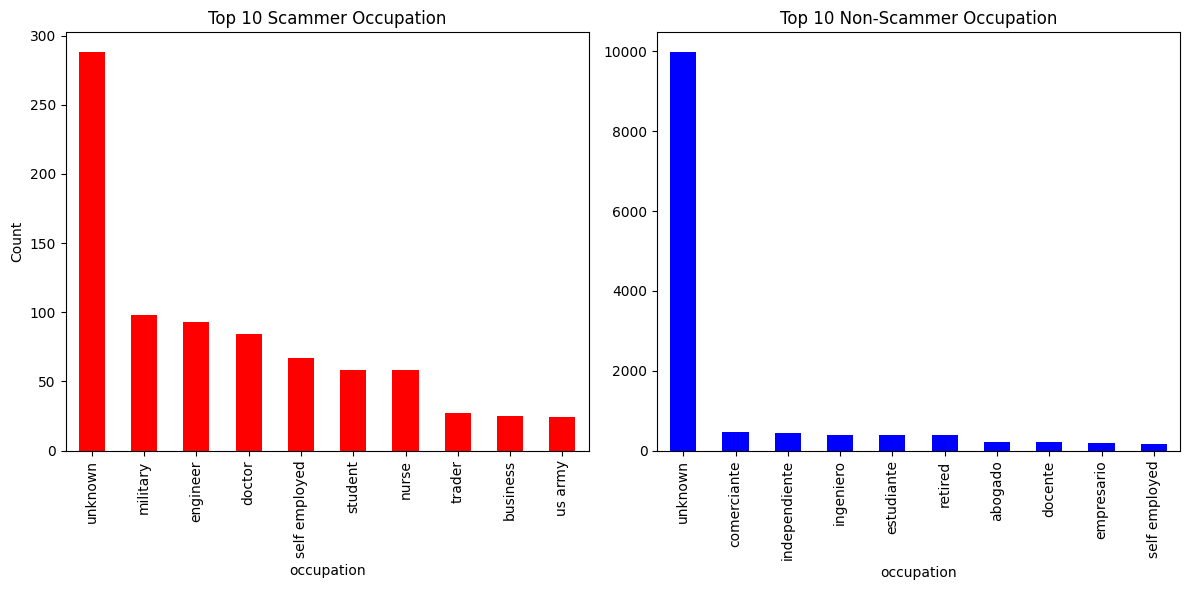

In [147]:
top_10_scammer_locations = scammer_df['occupation'].value_counts().nlargest(10)
top_10_non_scammer_locations = non_scammer_df['occupation'].value_counts().nlargest(10)

# # Exclude 'unknown'
# top_10_scammer_locations = scammer_df[scammer_df['occupation'] != 'unknown']['occupation'].value_counts().nlargest(10)
# top_10_non_scammer_locations = non_scammer_df[non_scammer_df['occupation'] != 'unknown']['occupation'].value_counts().nlargest(10)

# Create subplots for Location Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Top 10 Scammer Locations
top_10_scammer_locations.plot(kind='bar', ax=axes[0], color='red', title='Top 10 Scammer Occupation')
axes[0].set_ylabel('Count')

# Top 10 Non-Scammer Locations
top_10_non_scammer_locations.plot(kind='bar', ax=axes[1], color='blue', title='Top 10 Non-Scammer Occupation')

plt.tight_layout()
plt.show()

# Feature Engineering

In [148]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer

**For Baseline Result Only**

In [149]:
vectorizer = TfidfVectorizer()  # Using TF-IDF vectorizer
embeddings = vectorizer.fit_transform(merge_df['occupation']) 

eps_values = np.linspace(0.1, 1.5, 4)  
min_samples_values = [2, 4, 6, 8]  

best_eps = None
best_min_samples = None
best_silhouette = -1 

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(embeddings)

        unique_labels = np.unique(dbscan_labels)
        if len(unique_labels) > 1 and len(unique_labels) != 1:
            valid_labels = dbscan_labels != -1
            score = silhouette_score(embeddings[valid_labels], dbscan_labels[valid_labels])

            if score > best_silhouette:
                best_silhouette = score
                best_eps = eps
                best_min_samples = min_samples
        else:
            print(f"Skipping silhouette score calculation for eps={eps}, min_samples={min_samples} due to fewer than 2 clusters.")

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}")


Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=6 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=8 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=6 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=8 due to fewer than 2 clusters.
Best eps: 0.1, Best min_samples: 8, Best Silhouette Score: 0.9990745969683437


In [150]:
dbscan = DBSCAN(eps=0.1, min_samples=8, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)
merge_df['occupation_category'] = dbscan_labels

In [151]:
vectorizer = TfidfVectorizer()  # Using TF-IDF vectorizer
embeddings = vectorizer.fit_transform(merge_df['city']) 

eps_values = np.linspace(0.1, 1.5, 4)
min_samples_values = [2, 4, 6, 8]

best_eps = None
best_min_samples = None
best_silhouette = -1 

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(embeddings)

        unique_labels = np.unique(dbscan_labels)
        if len(unique_labels) > 1 and len(unique_labels) != 1:
            valid_labels = dbscan_labels != -1
            score = silhouette_score(embeddings[valid_labels], dbscan_labels[valid_labels])
            
            if score > best_silhouette:
                best_silhouette = score
                best_eps = eps
                best_min_samples = min_samples
        else:
            print(f"Skipping silhouette score calculation for eps={eps}, min_samples={min_samples} due to fewer than 2 clusters.")

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}")

Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=6 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=8 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=6 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=8 due to fewer than 2 clusters.
Best eps: 0.1, Best min_samples: 8, Best Silhouette Score: 0.9997042823367072


In [152]:
dbscan = DBSCAN(eps=0.1, min_samples=8, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)
merge_df['city_category'] = dbscan_labels

**For experiment 1 only**

In [24]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(merge_df['occupation'].tolist())

eps_values = np.linspace(0.1, 1.5, 4)  
min_samples_values = [2, 4, 6, 8] 

best_eps = None
best_min_samples = None
best_silhouette = -1  # Silhouette score ranges from -1 to 1, so start with a low value

# Grid search over combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN with current hyperparameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(embeddings)

        unique_labels = np.unique(dbscan_labels)
        if len(unique_labels) > 1 and len(unique_labels) != 1:
            valid_labels = dbscan_labels != -1
            score = silhouette_score(embeddings[valid_labels], dbscan_labels[valid_labels])
            
            # Update best configuration if current score is higher
            if score > best_silhouette:
                best_silhouette = score
                best_eps = eps
                best_min_samples = min_samples
        else:
            print(f"Skipping silhouette score calculation for eps={eps}, min_samples={min_samples} due to fewer than 2 clusters.")

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}")

# Best eps: 0.1, Best min_samples: 8, Best Silhouette Score: 0.9595791101455688

Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=6 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.0333333333333332, min_samples=8 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=6 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=8 due to fewer than 2 clusters.
Best eps: 0.1, Best min_samples: 8, Best Silhouette Score: 0.9595791101455688


In [25]:
dbscan = DBSCAN(eps=0.1, min_samples=8, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)
merge_df['occupation_category'] = dbscan_labels

In [34]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(merge_df['city'].tolist())  

eps_values = np.linspace(0.1, 1.5, 3)
min_samples_values = [2, 4, 6]

best_eps = None
best_min_samples = None
best_silhouette = -1 

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(embeddings)

        unique_labels = np.unique(dbscan_labels)
        if len(unique_labels) > 1 and len(unique_labels) != 1:
            valid_labels = dbscan_labels != -1
            score = silhouette_score(embeddings[valid_labels], dbscan_labels[valid_labels])
            
            if score > best_silhouette:
                best_silhouette = score
                best_eps = eps
                best_min_samples = min_samples
        else:
            print(f"Skipping silhouette score calculation for eps={eps}, min_samples={min_samples} due to fewer than 2 clusters.")

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}")

# Best eps: 0.1, Best min_samples: 2, Best Silhouette Score: 0.9911032915115356

Batches:   0%|          | 0/1008 [00:00<?, ?it/s]

Skipping silhouette score calculation for eps=0.7999999999999999, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=0.7999999999999999, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=0.7999999999999999, min_samples=6 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=2 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=4 due to fewer than 2 clusters.
Skipping silhouette score calculation for eps=1.5, min_samples=6 due to fewer than 2 clusters.
Best eps: 0.1, Best min_samples: 2, Best Silhouette Score: 0.9911032915115356


In [27]:
dbscan = DBSCAN(eps=0.1, min_samples=2, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)
merge_df['city_category'] = dbscan_labels

In [153]:
#one-hot encoding
one_hot_encoded = pd.get_dummies(merge_df[['status', 'ethnicity', 'religion', 'children', 'orientation', 'target']], drop_first=False)
one_hot_encoded = one_hot_encoded.astype(int)
merge_df_encoded = pd.concat([merge_df, one_hot_encoded], axis=1)

In [154]:
merge_df = merge_df_encoded.drop(['status', 'ethnicity', 'religion', 'children', 'orientation', 'target','location','occupation','city'],axis=1)

In [155]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32240 entries, 0 to 32239
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   age                                    32240 non-null  float64
 1   description                            32240 non-null  object 
 2   intent_Friendship                      32240 non-null  int64  
 3   intent_Romance                         32240 non-null  int64  
 4   intent_Serious_Relationship            32240 non-null  int64  
 5   intent_Marriage                        32240 non-null  int64  
 6   intent_Fun                             32240 non-null  int64  
 7   scammer                                32240 non-null  int64  
 8   occupation_category                    32240 non-null  int64  
 9   city_category                          32240 non-null  int64  
 10  status_divorced                        32240 non-null  int64  
 11  st

In [157]:
X_feature = merge_df.drop(['scammer', 'description'], axis=1)

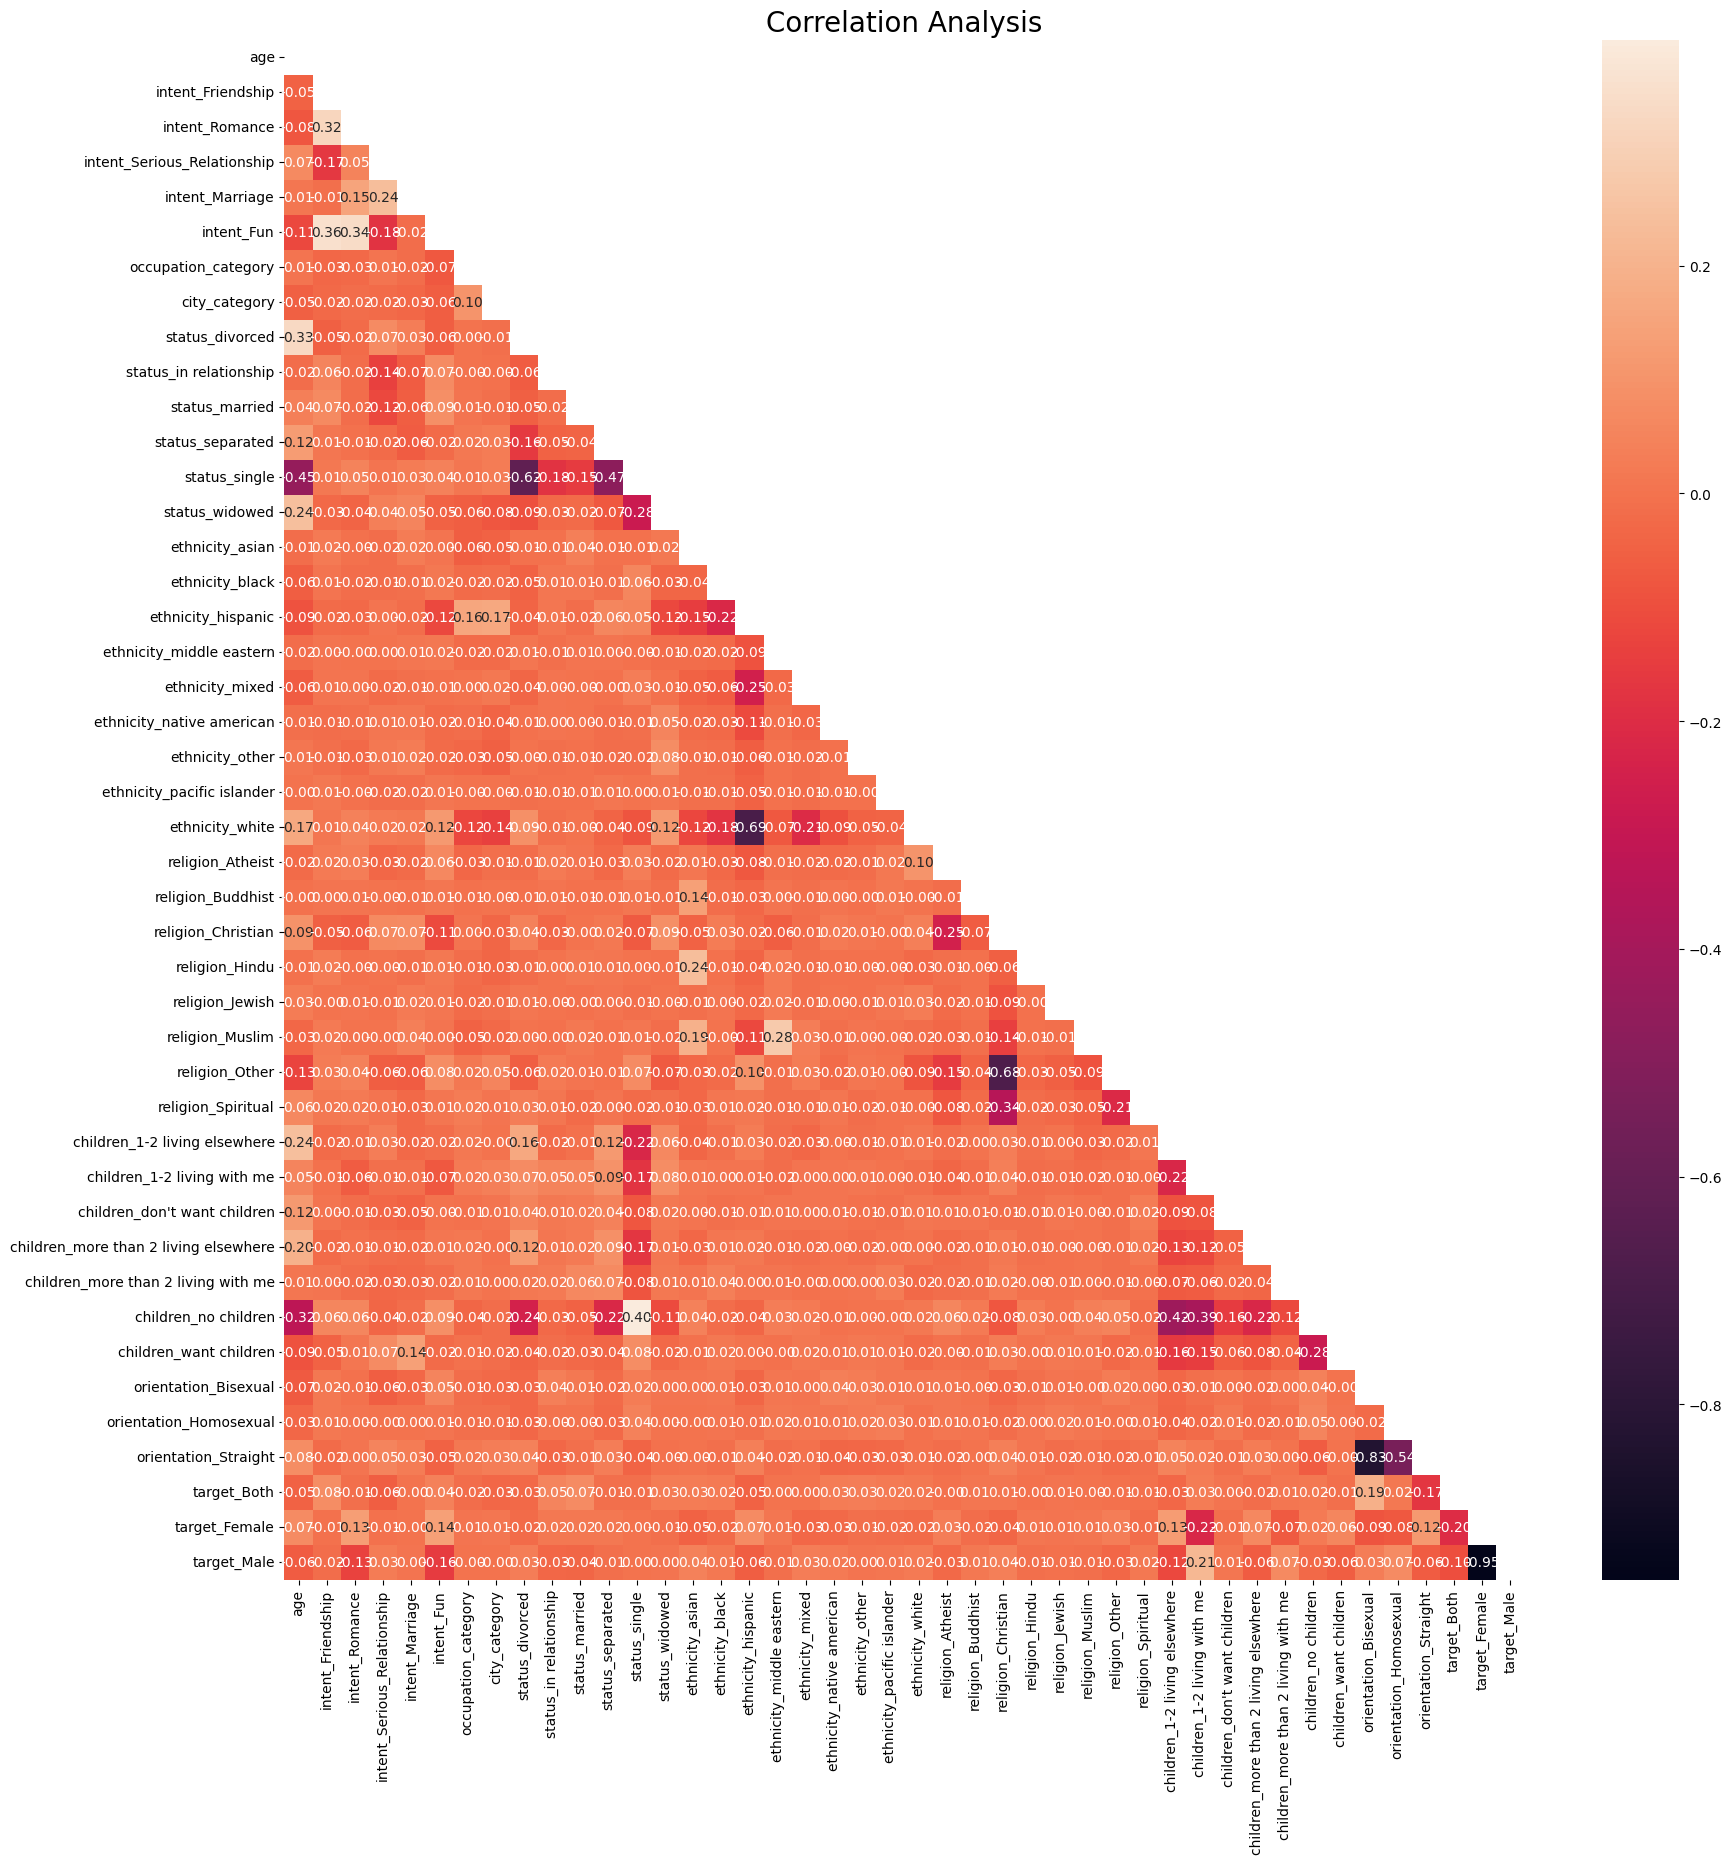

In [158]:
fig, ax = plt.subplots(1, figsize=(20,20))
corr = X_feature.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, fmt=".2f")
plt.title("Correlation Analysis", fontsize=20)
plt.show()

In [159]:
columns_to_drop = [
    "status_divorced",
    "ethnicity_hispanic",
    "religion_Other",
    "orientation_Straight",
    "target_Female"
]
X_feature = X_feature.drop(columns=columns_to_drop)

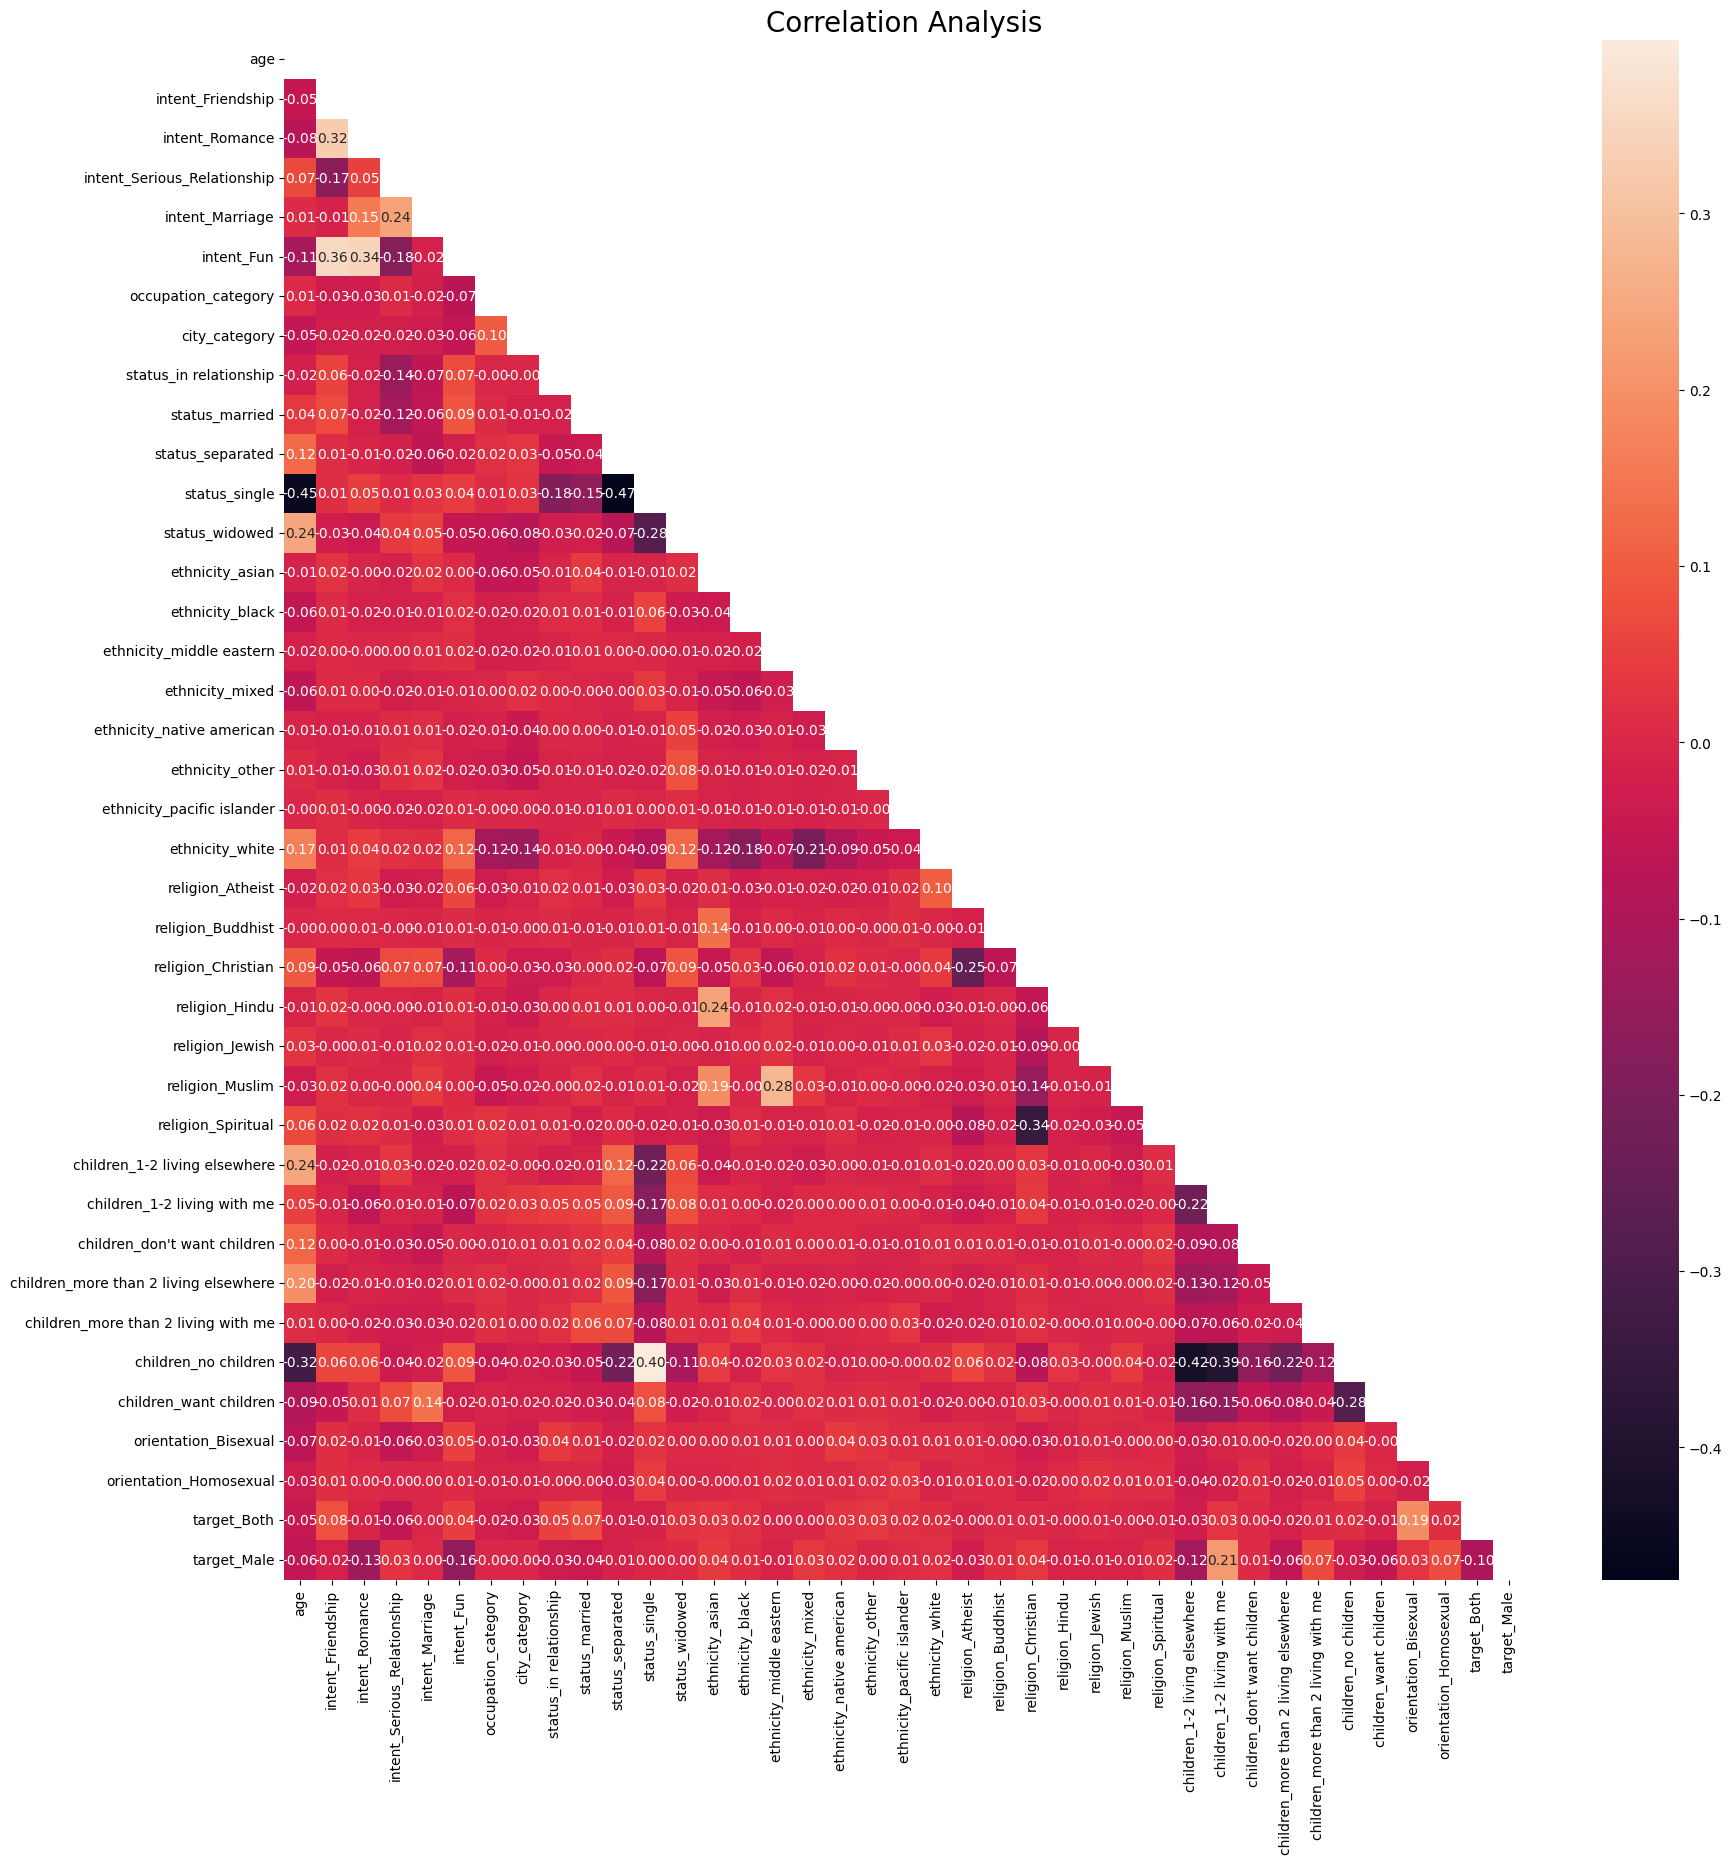

In [160]:
fig, ax = plt.subplots(1, figsize=(20,20))
corr = X_feature.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, fmt=".2f")
plt.title("Correlation Analysis", fontsize=20)
plt.show()

# Modelling

In [161]:
from sklearn.model_selection import train_test_split
X = merge_df.drop(['scammer', 'status_divorced', 'ethnicity_hispanic', 'religion_Other', 'orientation_Straight','target_Female'], axis=1)
y = merge_df['scammer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [162]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_num = X_train.drop(['description'], axis=1)  # Only numerical features
X_test_num = X_test.drop(['description'], axis=1)

X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [163]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_scaled, y_train)

In [164]:
sample_indices = undersampler.sample_indices_

X_train_resampled_text = X_train.iloc[sample_indices]['description']  # Drop NaN values if any
X_test_text = X_test['description']

In [165]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import hstack

# TF-IDF transformation
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_resampled_text)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Transform the test set descriptions with the same vectorizer
X_test_counts = count_vect.transform(X_test_text)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Combine the features
X_train_combined = hstack([X_train_resampled, X_train_tfidf])
X_test_combined = hstack([X_test_scaled, X_test_tfidf])

# Baseline Model

In [166]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [167]:
#Decision tree
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_combined, y_train_resampled)

y_pred = classifier.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9491315136476427
Precision: 0.5824175824175825
Recall: 0.9464285714285714
F1 Score: 0.7210884353741498
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      6000
           1       0.58      0.95      0.72       448

    accuracy                           0.95      6448
   macro avg       0.79      0.95      0.85      6448
weighted avg       0.97      0.95      0.95      6448



In [168]:
#SVM
svm = SVC(random_state=42)
svm.fit(X_train_combined, y_train_resampled)

y_pred_svm = svm.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.8898883374689827
Precision: 0.38198198198198197
Recall: 0.9464285714285714
F1 Score: 0.5442875481386392
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      6000
           1       0.38      0.95      0.54       448

    accuracy                           0.89      6448
   macro avg       0.69      0.92      0.74      6448
weighted avg       0.95      0.89      0.91      6448



In [169]:
#Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_combined, y_train_resampled)

y_pred_rf = rf_clf.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9291253101736973
Precision: 0.4948216340621404
Recall: 0.9598214285714286
F1 Score: 0.6529992406985574
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      6000
           1       0.49      0.96      0.65       448

    accuracy                           0.93      6448
   macro avg       0.75      0.94      0.81      6448
weighted avg       0.96      0.93      0.94      6448



In [170]:
#XGBoost
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(objective='binary:logistic',random_state=42)
xgb_clf.fit(X_train_combined, y_train_resampled)

y_pred_xgb = xgb_clf.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
report = classification_report(y_test, y_pred_xgb)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9576612903225806
Precision: 0.6251788268955651
Recall: 0.9754464285714286
F1 Score: 0.7619877942458588
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      6000
           1       0.63      0.98      0.76       448

    accuracy                           0.96      6448
   macro avg       0.81      0.97      0.87      6448
weighted avg       0.97      0.96      0.96      6448



In [171]:
#CatBoost
cat_clf = CatBoostClassifier(random_state=42,verbose=False)
cat_clf.fit(X_train_combined, y_train_resampled)

y_pred_cat = cat_clf.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_cat)
precision = precision_score(y_test, y_pred_cat)
recall = recall_score(y_test, y_pred_cat)
f1 = f1_score(y_test, y_pred_cat)
report = classification_report(y_test, y_pred_cat)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9526985111662531
Precision: 0.5994436717663422
Recall: 0.9620535714285714
F1 Score: 0.7386461011139674
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      6000
           1       0.60      0.96      0.74       448

    accuracy                           0.95      6448
   macro avg       0.80      0.96      0.86      6448
weighted avg       0.97      0.95      0.96      6448



# Experiment Model

# Decision Tree

In [46]:
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_combined, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [47]:
y_pred = classifier.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.961848635235732
Precision: 0.658307210031348
Recall: 0.9375
F1 Score: 0.7734806629834253
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      6000
           1       0.66      0.94      0.77       448

    accuracy                           0.96      6448
   macro avg       0.83      0.95      0.88      6448
weighted avg       0.97      0.96      0.96      6448



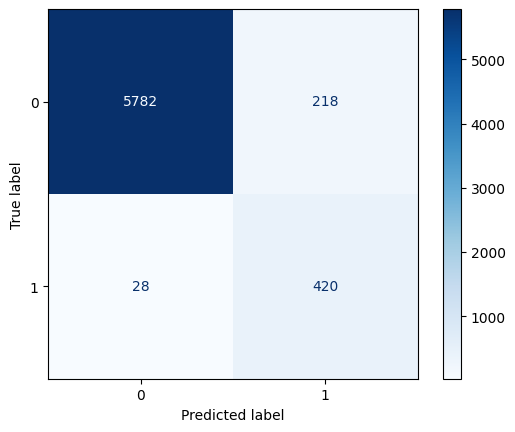

In [48]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Decision Tree Fine-tuning

In [57]:
params = {
    'max_depth': randint(1, 20),            
    'min_samples_leaf': randint(1, 10),       
    'criterion': ["gini", "entropy"],
    'max_features': ["auto", "sqrt", "log2", None],
    'class_weight': [None, "balanced"]
}
classifier = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=params,
    n_iter=100,                 
    scoring='f1',         
    cv=5,
    random_state=42         
)

random_search.fit(X_train_combined, y_train_resampled)
print("Tuned Hyperparameters :", random_search.best_params_)

Tuned Hyperparameters : {'class_weight': None, 'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 1}


In [58]:
# Tuned Hyperparameters : {'class_weight': None, 'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 1}
best_classifier = random_search.best_estimator_
y_pred_classifier = best_classifier.predict(X_test_combined)

In [59]:
accuracy = accuracy_score(y_test, y_pred_classifier)
precision = precision_score(y_test, y_pred_classifier)
recall = recall_score(y_test, y_pred_classifier)
f1 = f1_score(y_test, y_pred_classifier)
report = classification_report(y_test, y_pred_classifier)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9638647642679901
Precision: 0.6731078904991948
Recall: 0.9330357142857143
F1 Score: 0.7820392890551918
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      6000
           1       0.67      0.93      0.78       448

    accuracy                           0.96      6448
   macro avg       0.83      0.95      0.88      6448
weighted avg       0.97      0.96      0.97      6448



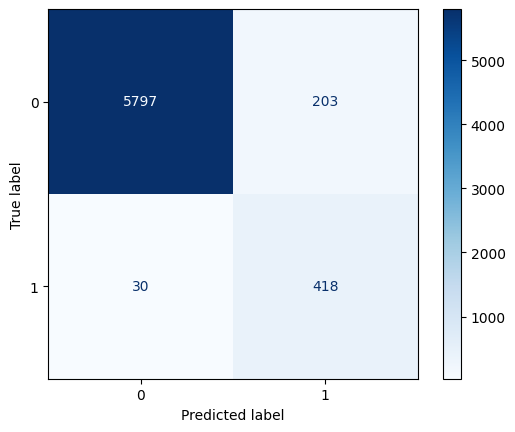

In [60]:
cm = confusion_matrix(y_test, y_pred_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# SVM

In [64]:
from scipy.stats import uniform
from sklearn.svm import SVC

In [61]:
svm = SVC(random_state=42)
svm.fit(X_train_combined, y_train_resampled)

SVC(random_state=42)

In [62]:
y_pred_svm = svm.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9108250620347395
Precision: 0.4364364364364364
Recall: 0.9732142857142857
F1 Score: 0.6026261230131306
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      6000
           1       0.44      0.97      0.60       448

    accuracy                           0.91      6448
   macro avg       0.72      0.94      0.78      6448
weighted avg       0.96      0.91      0.93      6448



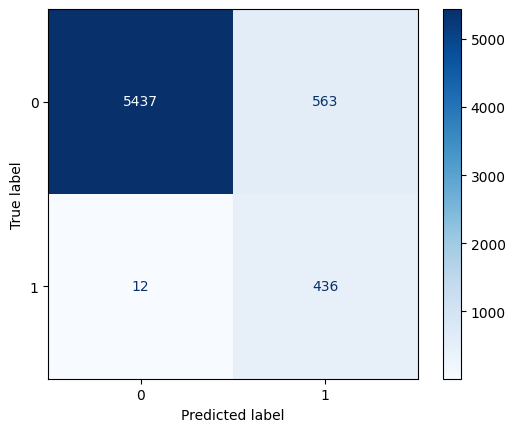

In [63]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# SVM Fine-tuning

In [69]:
params = {
    "C": uniform(0.1, 10),            
    "gamma": uniform(0.1, 10),
    "degree": randint(2, 5),
    "kernel": ["linear", "rbf", "poly", "sigmoid"]
}

svm = SVC(random_state=42)
random_search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=params,
    n_iter=100,                 
    cv=5,                    
    scoring='f1',        
    random_state=42            
)
random_search_svm.fit(X_train_combined, y_train_resampled)
print("Tuned Hyperparameters :", random_search_svm.best_params_)

Tuned Hyperparameters : {'C': 1.4662133144202882, 'degree': 3, 'gamma': 3.6949115121975518, 'kernel': 'linear'}


In [70]:
# Tuned Hyperparameters : {'C': 1.4662133144202882, 'degree': 3, 'gamma': 3.6949115121975518, 'kernel': 'linear'}
best_svm = random_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_combined)

In [71]:
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9706885856079405
Precision: 0.7119476268412439
Recall: 0.9709821428571429
F1 Score: 0.821529745042493
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      6000
           1       0.71      0.97      0.82       448

    accuracy                           0.97      6448
   macro avg       0.85      0.97      0.90      6448
weighted avg       0.98      0.97      0.97      6448



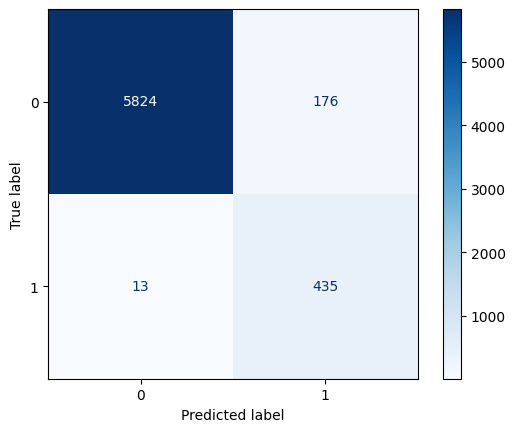

In [72]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_combined, y_train_resampled)

RandomForestClassifier(random_state=42)

In [75]:
y_pred_rf = rf_clf.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9347084367245657
Precision: 0.5159386068476978
Recall: 0.9754464285714286
F1 Score: 0.6749034749034749
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      6000
           1       0.52      0.98      0.67       448

    accuracy                           0.93      6448
   macro avg       0.76      0.95      0.82      6448
weighted avg       0.96      0.93      0.94      6448



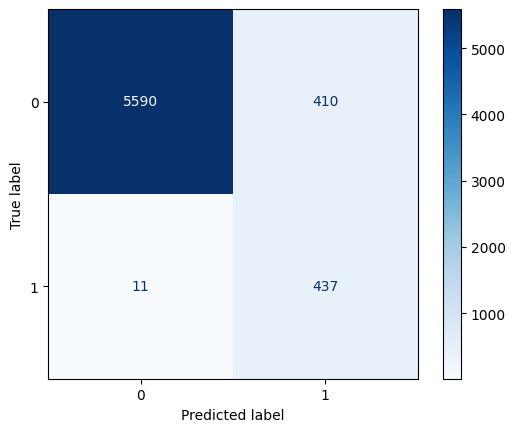

In [76]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Random Forest Fine-tuning

In [79]:
param_dist = {
    'n_estimators': randint(800, 1200),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [42],
    'verbose': [0]
}
rf_clf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(rf_clf, param_dist, n_iter=5, cv=5, scoring='f1', random_state=42)
random_search_rf.fit(X_train_combined, y_train_resampled)
print("Tuned Hyperparameters :", random_search_rf.best_params_)

Tuned Hyperparameters : {'max_depth': 97, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 991, 'random_state': 42, 'verbose': 0}


In [80]:
# Tuned Hyperparameters : {'max_depth': 97, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 991, 'random_state': 42, 'verbose': 0}
best_rf_clf = random_search_rf.best_estimator_
y_pred_rf = best_rf_clf.predict(X_test_combined)

In [81]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9575062034739454
Precision: 0.6246418338108882
Recall: 0.9732142857142857
F1 Score: 0.7609075043630017
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      6000
           1       0.62      0.97      0.76       448

    accuracy                           0.96      6448
   macro avg       0.81      0.96      0.87      6448
weighted avg       0.97      0.96      0.96      6448



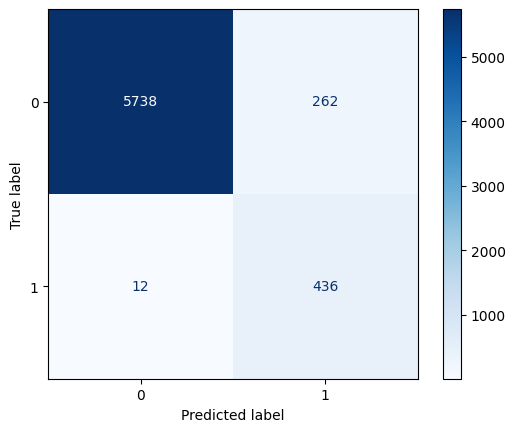

In [82]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# XGBoost

In [97]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(objective='binary:logistic',random_state=42)
xgb_clf.fit(X_train_combined, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [98]:
y_pred_xgb = xgb_clf.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
report = classification_report(y_test, y_pred_xgb)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9742555831265509
Precision: 0.7342192691029901
Recall: 0.9866071428571429
F1 Score: 0.8419047619047619
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      6000
           1       0.73      0.99      0.84       448

    accuracy                           0.97      6448
   macro avg       0.87      0.98      0.91      6448
weighted avg       0.98      0.97      0.98      6448



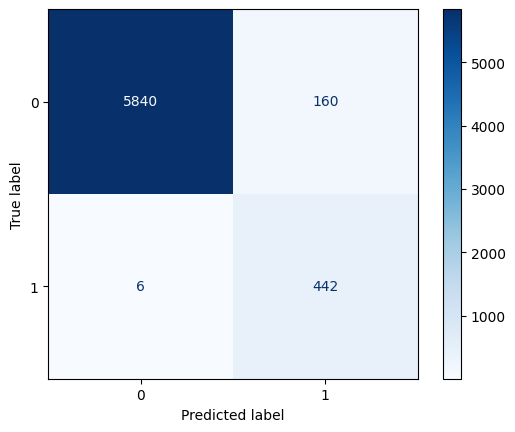

In [99]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# XGBoost Fine-tuning

In [101]:
xgb_clf = XGBClassifier(objective='binary:logistic',random_state=42)
param_dist = {
    'n_estimators': randint(800, 2000),
    'max_depth': randint(8, 12),
    'min_child_weight': randint(1, 6),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.3],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1],
    'scale_pos_weight':[1.5],
}
random_search_xgb = RandomizedSearchCV(estimator=xgb_clf,
                                   param_distributions=param_dist,
                                   n_iter=4,
                                   scoring='f1',
                                   cv=5,
                                   random_state=42,
                                   n_jobs=-1)

random_search_xgb.fit(X_train_combined, y_train_resampled)
print("Tuned Hyperparameters :", random_search_xgb.best_params_)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Tuned Hyperparameters : {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 1895, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1.5, 'subsample': 0.8}


In [102]:
#Tuned Hyperparameters : {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 1895, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1.5, 'subsample': 0.8}
best_xgb_clf = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_clf.predict(X_test_combined)

In [103]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
report = classification_report(y_test, y_pred_xgb)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9706885856079405
Precision: 0.705229793977813
Recall: 0.9933035714285714
F1 Score: 0.8248378127896201
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      6000
           1       0.71      0.99      0.82       448

    accuracy                           0.97      6448
   macro avg       0.85      0.98      0.90      6448
weighted avg       0.98      0.97      0.97      6448



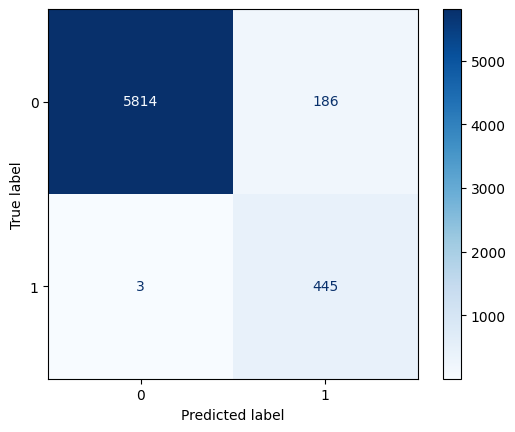

In [105]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# CatBoost

In [106]:
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
cat_clf = CatBoostClassifier(random_state=42,verbose=False)
cat_clf.fit(X_train_combined, y_train_resampled)

In [107]:
y_pred_cat = cat_clf.predict(X_test_combined)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_cat)
precision = precision_score(y_test, y_pred_cat)
recall = recall_score(y_test, y_pred_cat)
f1 = f1_score(y_test, y_pred_cat)
report = classification_report(y_test, y_pred_cat)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9744106699751861
Precision: 0.7370184254606366
Recall: 0.9821428571428571
F1 Score: 0.8421052631578947
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      6000
           1       0.74      0.98      0.84       448

    accuracy                           0.97      6448
   macro avg       0.87      0.98      0.91      6448
weighted avg       0.98      0.97      0.98      6448



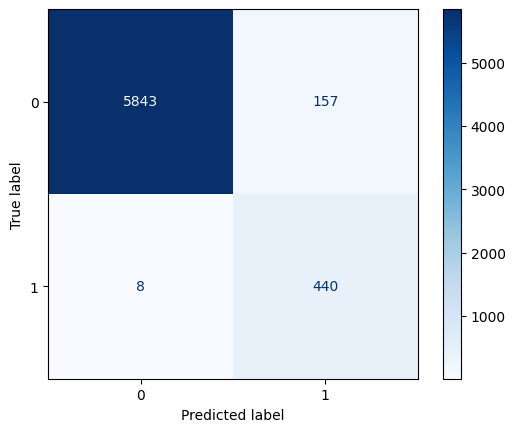

In [108]:
cm = confusion_matrix(y_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# CatBoost Fine-tuning

In [110]:
cat_clf = CatBoostClassifier()
param_dist = {
    'iterations': randint(800, 1200),
    'learning_rate': uniform(0.05, 0.2),
    'loss_function': ['CrossEntropy', 'Logloss'],
    'bootstrap_type': ['Bayesian', 'Bernoulli'],
    'eval_metric': ['F1'],
    'random_seed': [42],
    'verbose': [0]
}
# Perform random search
random_search_cat = RandomizedSearchCV(cat_clf, param_dist, n_iter=4, cv=5, scoring='f1')
random_search_cat.fit(X_train_combined, y_train_resampled)
print("Tuned Hyperparameters :", random_search_cat.best_params_)

Tuned Hyperparameters : {'bootstrap_type': 'Bernoulli', 'eval_metric': 'F1', 'iterations': 818, 'learning_rate': 0.1713158320857182, 'loss_function': 'CrossEntropy', 'random_seed': 42, 'verbose': 0}


In [111]:
#Tuned Hyperparameters : {'bootstrap_type': 'Bernoulli', 'eval_metric': 'F1', 'iterations': 818, 'learning_rate': 0.1713158320857182, 'loss_function': 'CrossEntropy', 'random_seed': 42, 'verbose': 0}
best_cat_clf = random_search_cat.best_estimator_
y_pred_cat = best_cat_clf.predict(X_test_combined)

In [112]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_cat)
precision = precision_score(y_test, y_pred_cat)
recall = recall_score(y_test, y_pred_cat)
f1 = f1_score(y_test, y_pred_cat)
report = classification_report(y_test, y_pred_cat)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9767369727047146
Precision: 0.7586805555555556
Recall: 0.9754464285714286
F1 Score: 0.8535156250000001
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      6000
           1       0.76      0.98      0.85       448

    accuracy                           0.98      6448
   macro avg       0.88      0.98      0.92      6448
weighted avg       0.98      0.98      0.98      6448



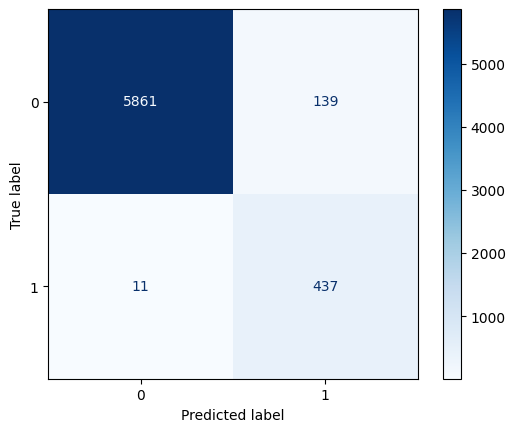

In [113]:
cm = confusion_matrix(y_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_cat_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Ensemble Model

In [116]:
clf1 = DecisionTreeClassifier(class_weight= None,criterion='entropy',max_depth=13, max_features=None,min_samples_leaf=1, random_state=42)
# Tuned Hyperparameters : {'class_weight': None, 'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 1}

clf2 = SVC(C = 1.4662133144202882, degree=3,gamma = 3.6949115121975518, kernel = 'linear', random_state=42, probability=True)
# Tuned Hyperparameters : {'C': 1.4662133144202882, 'degree': 3, 'gamma': 3.6949115121975518, 'kernel': 'linear'}

clf3 = RandomForestClassifier(max_depth=97, max_features=None, min_samples_leaf=6, min_samples_split=3, n_estimators=991, random_state= 42, verbose=0)
# Tuned Hyperparameters : {'max_depth': 97, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 991, 'random_state': 42, 'verbose': 0}

clf4 = XGBClassifier(colsample_bytree=0.8,gamma=0.3,max_depth=8,min_child_weight=3,n_estimators=1895,reg_alpha=1,reg_lambda=1,scale_pos_weight=1.5,subsample=0.8,random_state=42)
# Tuned Hyperparameters : {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 1895, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1.5, 'subsample': 0.8}

clf5 = CatBoostClassifier(bootstrap_type= 'Bernoulli',eval_metric='F1',iterations=818, learning_rate=0.1713158320857182, loss_function='CrossEntropy',random_seed=42, verbose=0)
#Tuned Hyperparameters : {'bootstrap_type': 'Bernoulli', 'eval_metric': 'F1', 'iterations': 818, 'learning_rate': 0.1713158320857182, 'loss_function': 'CrossEntropy', 'random_seed': 42, 'verbose': 0}

In [119]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', clf1),
        ('svc', clf2),
        ('random_forest', clf3),
        ('xgb', clf4),
        ('catboost', clf5)
    ],
    voting='soft',
    weights=[0.7820392890551918, 0.821529745042493, 0.7609075043630017,0.8248378127896201,0.8535156250000001]
)

# Fit ensemble model
voting_clf.fit(X_train_combined, y_train_resampled)

# Evaluate
y_pred_voting = voting_clf.predict(X_test_combined)

In [121]:
accuracy = accuracy_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting)
recall = recall_score(y_test, y_pred_voting)
f1 = f1_score(y_test, y_pred_voting)
report = classification_report(y_test, y_pred_voting)

# Print performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Classification Report:\n', report)

Accuracy: 0.9733250620347395
Precision: 0.7277227722772277
Recall: 0.984375
F1 Score: 0.8368121442125237
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      6000
           1       0.73      0.98      0.84       448

    accuracy                           0.97      6448
   macro avg       0.86      0.98      0.91      6448
weighted avg       0.98      0.97      0.98      6448

